## SpeakQL A/B User Study Overview and Discussion of Study Design Challenges

#### SpeakQL
SpeakQL is an extension of SQL syntax that is intented to make speech-driven querying more natural while retaining the benefit correctness by construction of a formal language.

##### Features:
- Synonyms (e.g. Get area from the room table)
- Alternate ordering (e.g. From the room table get area)
- Natural functions (e.g. What is the average of area in the room table)
- Unbundling - feature allows specifying complex queries one table at a time.



### Study Design

#### Objective: 
Compare SpeakQL dialect to SQL dialect in terms of planning time, total time, and number of attempts to form a correct query.

#### Context:
Online using Zoom and a custom-built user interface with audio recording and live speech-to-text transcription.

#### Participants:
- Gradudate and Undergraduate UCSD students from CSE and Business Analytics programs.
- 23 Participants total (one dropped from data)

#### Design Considerations:
- Used counterbalancing to reduce learning effect.
  - SQL first, then SpeakQL or SpeakQL first, then SQL
- Practice session
  - 3 queries in dialect 1, then repeat in dialect 2
- Measured session
  - 12 queries in dialect 1, then repeat in dialect 2
- Compensation based on number of queries completed
- Queries increased in complexity as study progressed.
- SpeakQL feature usage was optional.

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import scipy.stats as stats
from scipy.stats import normaltest
from scipy.stats import mannwhitneyu as mwu
from scipy.stats import wilcoxon as wil
from scipy.stats import ttest_ind
from scipy.ndimage import median
from scipy.ndimage import mean
from IPython.display import display
pd.options.display.float_format = '{:,.3f}'.format

df = pd.read_excel(
    './data/df/sample-distribution-and-tests-df.xlsx'
)
df = df.query("ispractice == 0")
df = df.query("idparticipant != 18")
df['relative_step'] = df.apply(
    lambda row: row.idstep - 6 if row.idstep < 19 else row.step - 18, 
    axis = 1
)
df['second_half'] = df.apply(
    lambda row: 0 if row.idstep <= 18 else 1,
    axis = 1
)

### Results Summary

#### Overall Distribution
In aggregate, planning time showed a right tail distribution for both SpeakQL and SQL

#### SpeakQL - First Attempt Planning Time:

<AxesSubplot:>

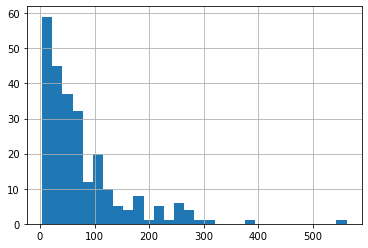

In [2]:
df.query('language == "speakql"').first_pt.hist(bins = 30)

#### SQL - First Attempt Planning Time:

<AxesSubplot:>

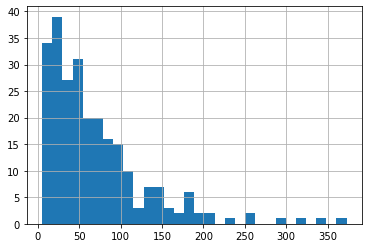

In [3]:
df.query('language == "sql"').first_pt.hist(bins = 30)

### First Planning Time Distribution by query

A Shapiro-Wilkes test of normality reveals that most distributions by query are not normal (query 10 is an exception)

In [4]:
df.columns

Index(['Unnamed: 0', 'idparticipant', 'idsession', 'idattemptsubmission',
       'idquery', 'idstep', 'attemptnum', 'total_time', 'recording_time',
       'planning_time', 'tot_pt', 'first_pt', 'tot_tt', 'groupnum', 'step',
       'speakql_first', 'language', 'ispractice', 'correct', 'usedspeakql',
       'complexity', 'normalized', 'is_complex', 'num_mods', 'num_joins',
       'num_funcs', 'num_proj', 'num_tables', 'num_selections',
       'used_unbundling', 'unbundling_possible', 'used_natural_functions',
       'natural_functions_possible', 'used_mod_ordering',
       'mod_ordering_possible', 'used_expression_ordering',
       'expression_ordering_possible', 'used_synonyms', 'synonyms_possible',
       'relative_step', 'second_half'],
      dtype='object')

In [5]:
d = {"Query": [], "Stat": [], "P":[], "Normal": []}
for i in range(1, 13):
    stat, pval = stats.shapiro(df.query("relative_step == " + str(i)).first_pt)
    d["Query"].append(i)
    d["Stat"].append(stat)
    d["P"].append(pval)
    d["Normal"].append(pval > 0.05)
pd.DataFrame(data = d)

,Query,Stat,P,Normal
0,1,0.917,0.004,False
1,2,0.904,0.001,False
2,3,0.799,0.000,False
3,4,0.918,0.004,False
4,5,0.871,0.000,False
5,6,0.863,0.000,False
6,7,0.841,0.000,False
7,8,0.903,0.002,False
8,9,0.857,0.000,False
9,10,0.947,0.069,True


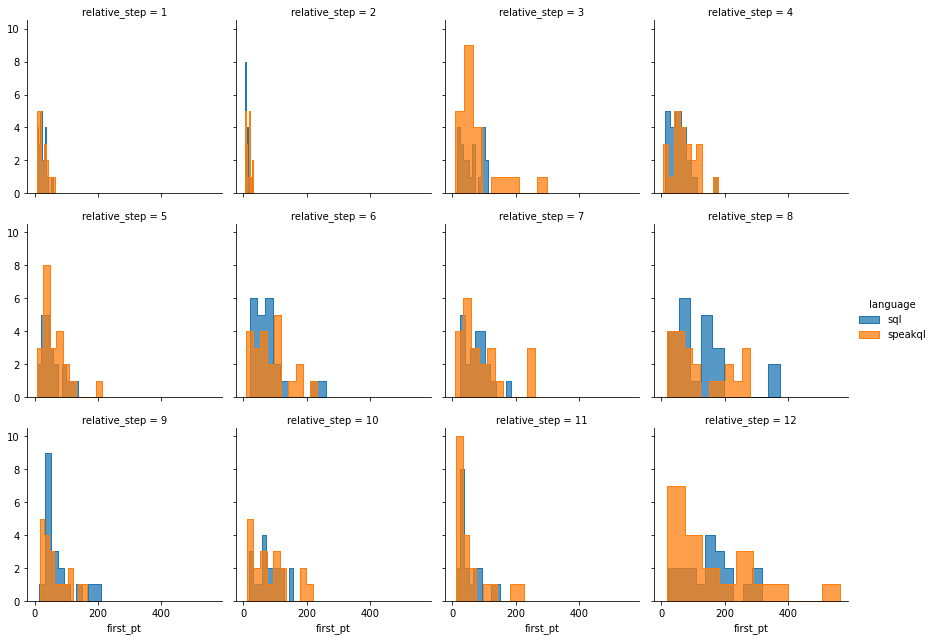

In [6]:
g = sns.FacetGrid(df, col='relative_step', col_wrap = 4, hue='language')
g.map_dataframe(
    sns.histplot, 
    'first_pt', 
    bins = 10, 
    discrete = False, 
    element = 'step',
    legend = True
)
g.add_legend()

### Number of AttemptsDistribution by query


In [7]:
d = {"Query": [], "Stat": [], "P":[], "Normal": []}
for i in range(1, 13):
    stat, pval = stats.shapiro(df.query("relative_step == " + str(i)).attemptnum)
    d["Query"].append(i)
    d["Stat"].append(stat)
    d["P"].append(pval)
    d["Normal"].append(pval > 0.05)
pd.DataFrame(data = d)

,Query,Stat,P,Normal
0,1,0.276,0.000,False
1,2,0.137,0.000,False
2,3,0.678,0.000,False
3,4,0.547,0.000,False
4,5,0.593,0.000,False
5,6,0.751,0.000,False
6,7,0.598,0.000,False
7,8,0.786,0.000,False
8,9,0.731,0.000,False
9,10,0.698,0.000,False


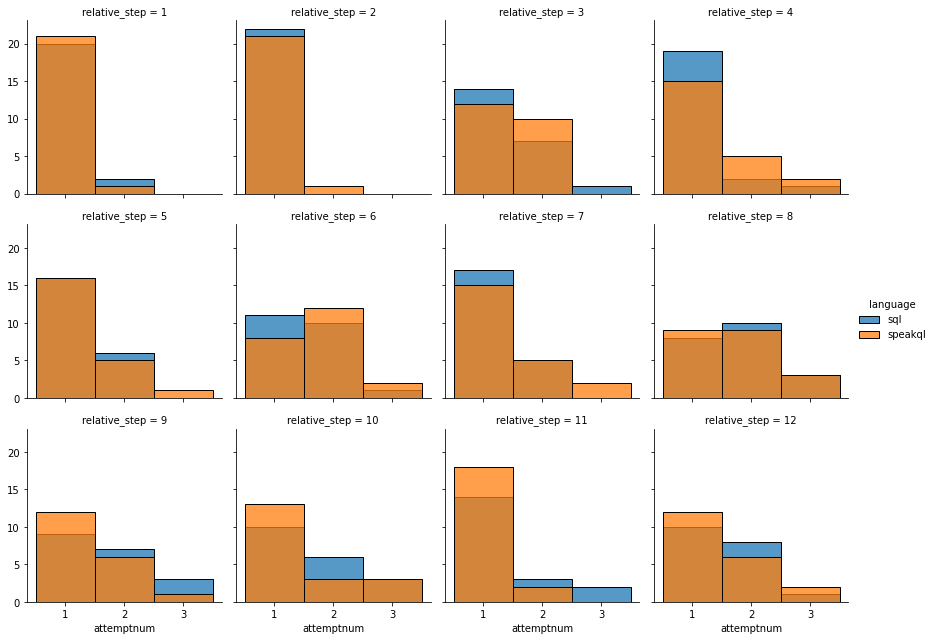

In [8]:
g = sns.FacetGrid(df, col='relative_step', col_wrap = 4, hue='language')
g.map_dataframe(
    sns.histplot, 
    'attemptnum', 
    bins = 3, 
    discrete = True, 
    element = 'bars',
    legend = True
)
g.add_legend()

### Mann-Whitney U-Test on Non-Parametric Data

In [9]:

dep_vars = ['first_pt', 'tot_tt', 'attemptnum']
result_dfs = []
# dep_vars = ['recording_time']
df_sql = df.query("language == 'sql'")
df_speakql = df.query("language == 'speakql'")

for dep_var in dep_vars:
    mwu_results = {}
    for idquery in df.idquery.unique():
        subset_sql = df_sql.where(df_sql.idquery == idquery).dropna(how = 'all')
        subset_speakql = df_speakql.where(df_speakql.idquery == idquery).dropna(how = 'all')
        mwu_results[(dep_var, idquery)] = {
            'u_test_pval' : mwu(
            x = subset_sql[dep_var],
            y = df_speakql.where(df_speakql.idquery == idquery).dropna(how = 'all')[dep_var]
            )[1],
            'median_sql' : subset_sql[dep_var].median(),
            'median_speakql' : subset_speakql[dep_var].median()
        }
    result_dfs.append(pd.DataFrame(mwu_results))


In [10]:
for result in result_dfs:
    display(result)

first_pt                                                    \
                     2      3      4      7      9      10     11      12   
u_test_pval       0.248  0.349  0.336  0.070  0.380  0.341  0.481   0.420   
median_sql       20.500 10.500 53.000 51.500 45.500 69.500 79.000 105.000   
median_speakql   22.000 11.000 58.500 66.500 48.500 68.500 65.000  96.000   

                                             
                   13     14     15      17  
u_test_pval     0.175  0.471  0.254   0.311  
median_sql     52.000 73.000 37.000 147.000  
median_speakql 50.000 68.000 36.000 119.000

tot_tt                                                       \
                   2      3      4       7      9       10      11      12   
u_test_pval     0.495  0.421  0.259   0.013  0.319   0.140   0.148   0.330   
median_sql     34.500 20.000 78.500  78.000 83.500 113.500 115.000 160.000   
median_speakql 32.500 20.500 93.500 115.500 91.000 137.500 130.500 192.000   

                                               
                    13      14     15      17  
u_test_pval      0.047   0.207  0.146   0.406  
median_sql     137.000 142.000 92.000 260.000  
median_speakql 115.000 116.000 86.000 302.000

attemptnum                                                  \
                       2     3     4     7     9     10    11    12    13   
u_test_pval         0.286 0.170 0.326 0.084 0.470 0.168 0.212 0.408 0.136   
median_sql          1.000 1.000 1.000 1.000 1.000 1.500 1.000 2.000 2.000   
median_speakql      1.000 1.000 1.000 1.000 1.000 2.000 1.000 2.000 1.000   

                                  
                  14    15    17  
u_test_pval    0.216 0.086 0.393  
median_sql     1.000 1.000 1.000  
median_speakql 1.000 1.000 1.000

#### Box and Whisker plots of performance by dialect


In [11]:
df_temp = df.rename(columns={
    'first_pt': 'First Attempt Planning Time',
    'relative_step': 'Query'
})
df_temp['Query'] = df_temp.apply(lambda row: str(int(row.Query)), axis=1)
df_temp['language'] = df_temp.apply(lambda row: {'sql': 'sql (L)', 'speakql': 'speakql (R)'}[row.language], axis=1)

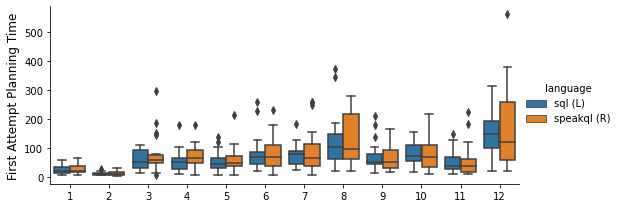

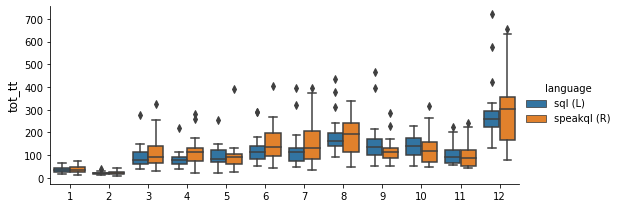

In [12]:
for var in ['First Attempt Planning Time', 'tot_tt']:
    g = sns.catplot(
        kind='box',data = df_temp, 
        x = 'Query', 
        y = var, 
        hue = 'language', 
        orient = 'v',
        aspect = 2.4,
        height = 3
    )
    g.set_axis_labels("", var, fontsize='large')
    hatches = ['.', '+']

In [13]:
attempt_legend = {1: "1 *", 2: "2 +", 3: "3 X"}

df_temp['Number of Attempts'] = df.apply(lambda row: attempt_legend[int(row.attemptnum)], axis = 1)
df_temp['Dialect'] = df.apply(lambda row: 'SQL' if row.language == 'sql' else 'SPK', axis = 1)
df_temp['Q'] = df.apply(lambda row: str(int(row.relative_step)), axis = 1)
hatches = ['.', '.', '+', '+', 'x', 'x']

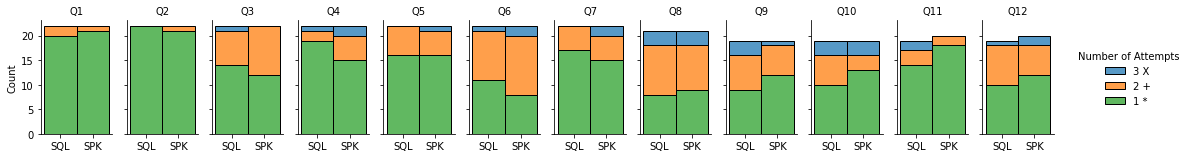

In [14]:
g = sns.displot(
    df_temp, 
    x='Dialect', 
    col='Q', 
    hue='Number of Attempts', 
    hue_order=['3 X', '2 +', '1 *'],
    col_wrap=12,
    height=2.5,
    aspect=.5,
    kind='hist',
    multiple='stack',
    stat='count'
)
g.set_axis_labels("")
g.set_titles("Q" + "{col_name}")


### Group Effect Analysis
- We used counterbalancing between two groups to offset learning effect.
- Participants were randomly assigned to either group 1 or group 2
  - Group 1: SpeakQL first, then SQL
  - Group 2: SQL first, then SpeakQL

#### Feature Usage by Group
Feature usage was optional; and we observed different usage rates between groups.
  - Participants in group 1 (SpeakQL First) used unbundling much more frequently
  - Participants in group 2 (SQL First) used other features slightly more frequently

In [15]:
used_df = pd.melt(
    df, id_vars =['groupnum', 'idparticipant', 'idsession', 'idstep'], 
    value_vars = [
        'used_synonyms',
        'used_expression_ordering',
        'used_mod_ordering',
        'used_natural_functions',
        'used_unbundling'
    ]
)

possible_df = pd.melt(
    df, id_vars =['groupnum', 'idparticipant', 'idsession', 'idstep'], 
    value_vars = [
        'synonyms_possible',
        'expression_ordering_possible',
        'mod_ordering_possible',
        'natural_functions_possible',
        'unbundling_possible'
    ]
)

used_sum = used_df[['groupnum', 'variable', 'value']].groupby(
    ['groupnum', 'variable']
).sum()

possible_sum = possible_df[['groupnum', 'variable', 'value']].groupby(
    ['groupnum', 'variable']
).sum()

sum_compare = used_sum
sum_compare = sum_compare.rename(columns = {'value' : 'used'}).reset_index()
sum_compare['possible'] = possible_sum.reset_index().value

sum_compare['perc_usage'] = sum_compare.used / sum_compare.possible


,groupnum,variable,used,possible,perc_usage
0,group1,used_expression_ordering,8.000,123.000,0.065
5,group2,used_expression_ordering,13.000,118.000,0.110
1,group1,used_mod_ordering,1.000,37.000,0.027
6,group2,used_mod_ordering,1.000,38.000,0.026
2,group1,used_natural_functions,65.000,81.000,0.802
7,group2,used_natural_functions,73.000,78.000,0.936
3,group1,used_synonyms,57.000,123.000,0.463
8,group2,used_synonyms,71.000,118.000,0.602
4,group1,used_unbundling,85.000,90.000,0.944
9,group2,used_unbundling,36.000,88.000,0.409


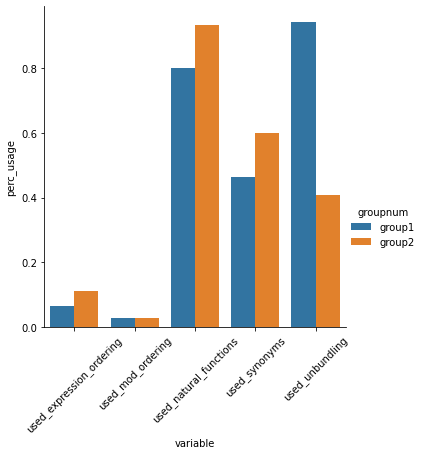

In [16]:
g = sns.catplot(
    data = sum_compare,
    kind = 'bar',
    x = 'variable',
    y = 'perc_usage',
    hue = 'groupnum'
)
g.set_xticklabels(rotation = 45)
display(sum_compare.sort_values(by=['variable']))

#### Group Median and Distribution Observations by Dependent Variable

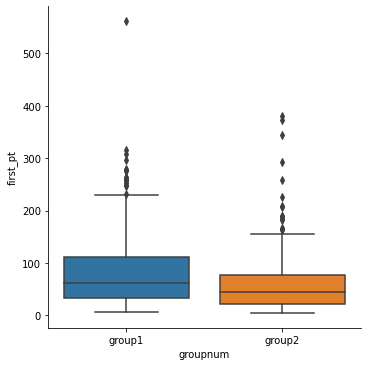

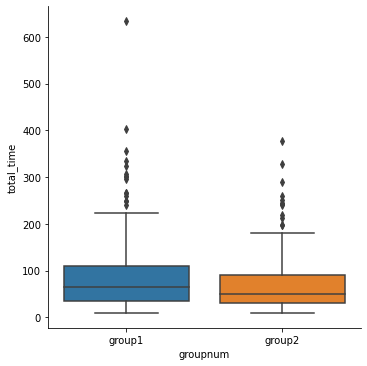

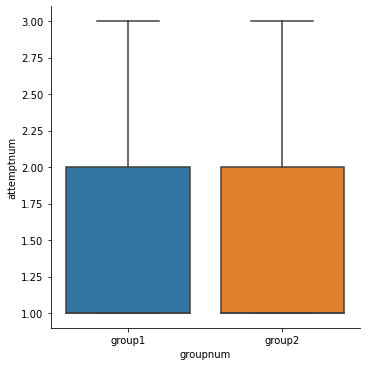

In [17]:
g = sns.catplot(x='groupnum', y='first_pt', data=df.sort_values(by='groupnum'), kind='box')
g3 = sns.catplot(x='groupnum', y='total_time', data=df.sort_values(by='groupnum'), kind='box')
g4 = sns.catplot(x='groupnum', y='attemptnum', data=df.sort_values(by='groupnum'), kind='box')


#### Observation of asymmetric learning
The following charts show performance by language between the first and second half of the experiment.

We can see that for Group 1 (SpeakQL first), their performance in the second half (using SQL) experienced less improvement than participants in Group 2 (SQL first).

This observation suggests some sort of asymmetry in our data.

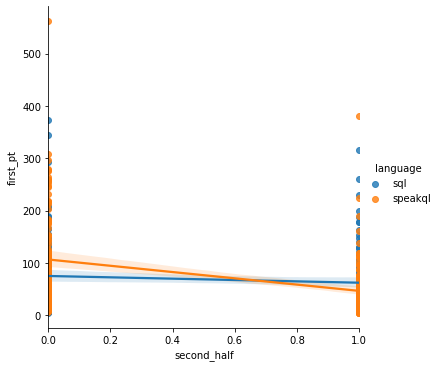

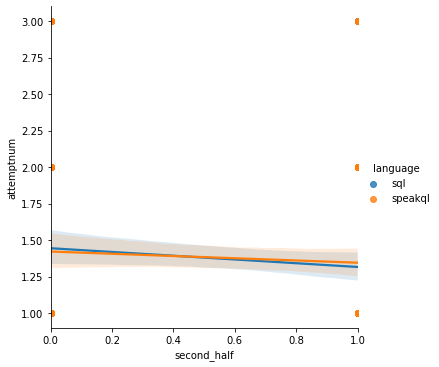

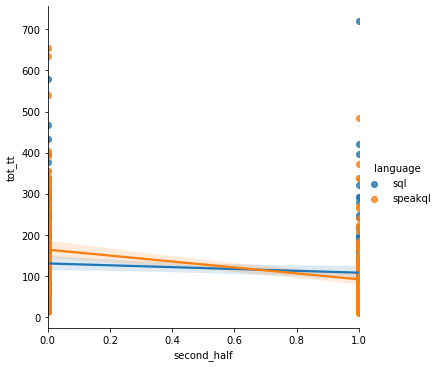

In [18]:
sns.lmplot(data = df,
           x = 'second_half',
           y = 'first_pt',
           hue = 'language'
          )

sns.lmplot(data = df,
           x = 'second_half',
           y = 'attemptnum',
           hue = 'language'
          )

sns.lmplot(data = df,
           x = 'second_half',
           y = 'tot_tt',
           hue = 'language'
          )

#### Reconsidering Performance Data based on Groups

- Overall, the SpeakQL-first group performed more slowly in their first dialect (SpeakQL) than the SQL-first group performed in their first dialect (SQL). This suggests a SpeakQL learning curve.

- Strangely, we observe the opposite in the second dialects. The SpeakQL-first group performed more slowly in their second dialect (SQL), than the SQL-first group performed using SpeakQL.

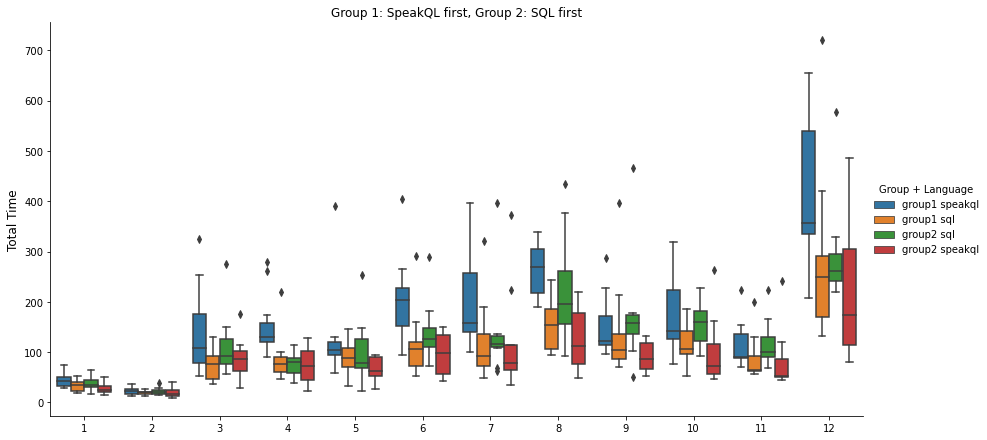

In [19]:
df_temp = df.rename(columns={
    'tot_tt': 'Total Time',
    'relative_step': 'Query'
})
df_temp['Total Time'] = df_temp['Total Time'].astype(int)
df_temp['Query'] = df_temp.apply(lambda row: str(int(row.Query)), axis=1)
df_temp['Group + Language'] = df_temp.apply(lambda row: row.groupnum + " " + row.language, axis = 1) 

g = sns.catplot(
    kind='box',data = df_temp.sort_values(by=['groupnum', 'step']), 
    x = 'Query', 
    y = 'Total Time', 
    hue = 'Group + Language', 
    orient = 'v',
    aspect = 2,
    height = 6,
    legend = True
)

g.set_axis_labels("", "Total Time", fontsize='large')
g.set(title = "Group 1: SpeakQL first, Group 2: SQL first")

We observe this disparity in both first attempt planning time, and total time.

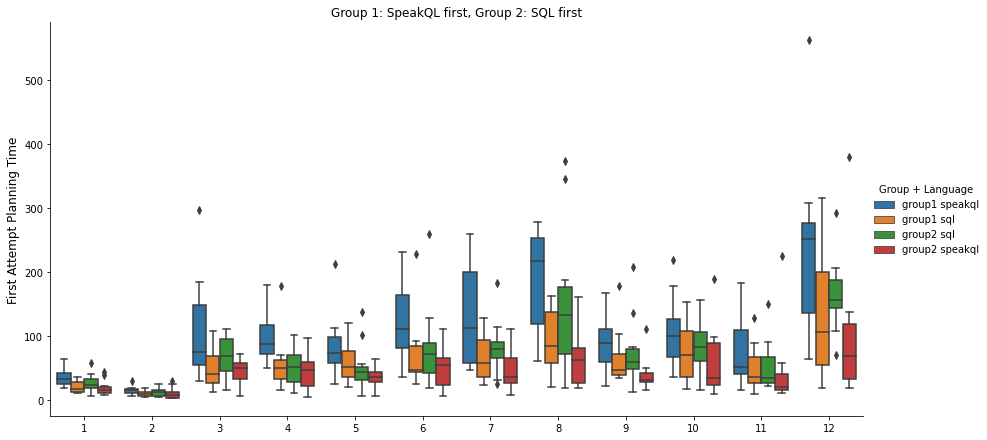

In [20]:
df_temp = df.rename(columns={
    'first_pt': 'First Attempt Planning Time',
    'relative_step': 'Query'
})
df_temp['First Attempt Planning Time'] = df_temp['First Attempt Planning Time'].astype(int)
df_temp['Query'] = df_temp.apply(lambda row: str(int(row.Query)), axis=1)
df_temp['Group + Language'] = df_temp.apply(lambda row: row.groupnum + " " + row.language, axis = 1) 

g = sns.catplot(
    kind='box',data = df_temp.sort_values(by=['groupnum', 'step']), 
    x = 'Query', 
    y = 'First Attempt Planning Time', 
    hue = 'Group + Language', 
    orient = 'v',
    aspect = 2,
    height = 6,
    legend = True
)

g.set_axis_labels("", "First Attempt Planning Time", fontsize='large')
g.set(title = "Group 1: SpeakQL first, Group 2: SQL first")

#### Comparison between those who used unbundling, and those who didn't

- When we distinguish between SpeakQL attempts where unbundling was used, we see that there is a more even spread between groups 1 and 2 and their dialects. Participants who avoided unbundling in the second half (SQL first group) performed better than participants who used unbundling.
- We think this is due to them essentially re-stating the same SQL query from the first half

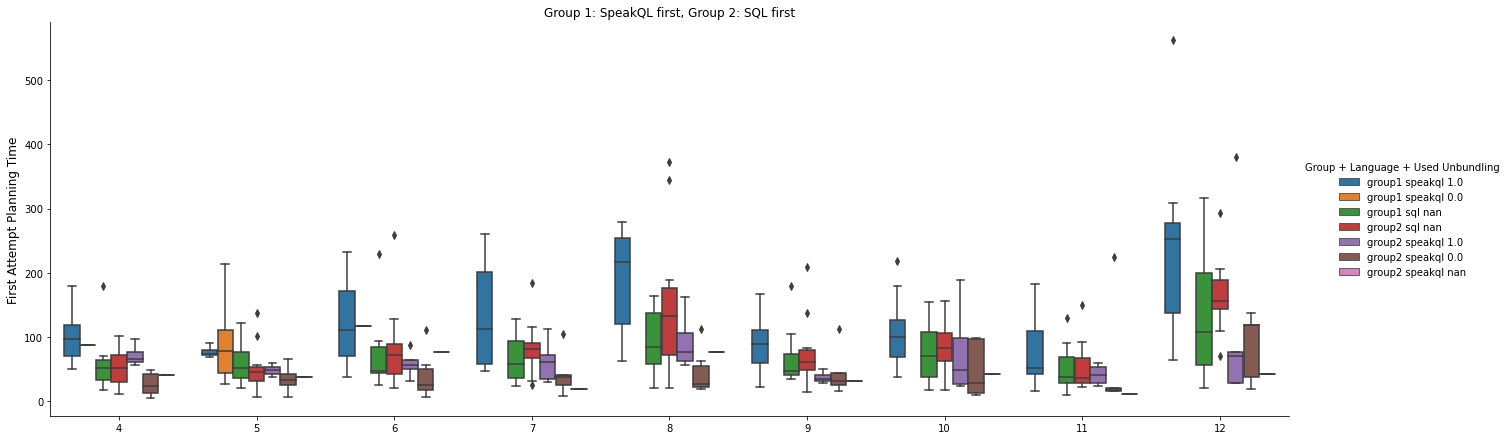

In [21]:
df_temp = df.rename(columns={
    'first_pt': 'First Attempt Planning Time',
    'relative_step': 'Query'
})
df_temp['First Attempt Planning Time'] = df_temp['First Attempt Planning Time'].astype(int)
df_temp['query_int'] = df_temp.Query
df_temp['Query'] = df_temp.apply(lambda row: str(int(row.Query)), axis=1)
df_temp['Group + Language + Used Unbundling'] = df_temp.apply(lambda row: row.groupnum + " " + row.language + " " + str(row.used_unbundling), axis = 1) 

g = sns.catplot(
    kind='box',
    data = df_temp.sort_values(by=['groupnum', 'step']).query("query_int > 3"), 
    x = 'Query', 
    y = 'First Attempt Planning Time', 
    hue = 'Group + Language + Used Unbundling', 
    orient = 'v',
    aspect = 3,
    height = 6,
    legend = True
)

g.set_axis_labels("", "First Attempt Planning Time", fontsize='large')
g.set(title = "Group 1: SpeakQL first, Group 2: SQL first")

### Discussion

#### Some Ideas:
- Evaluate only one feature: Unbundling
- Make unbundling usage mandator
- Switch to in-person to eliminate covert behaviors
- Spread session apart by several days to facilitate "unlearning"